# Data cleaning & ML methods

In [1]:
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

## Some useful functions

In [3]:
def get_titles(path):
    # Get the variables' names of a dataset as a list
    with open(path, 'r') as f:
        reader = csv.reader(f)
        result = list(reader)
        result = result[0]  # First line of the dataset
        result = [x.lower() for x in result]
    return result



def check_variables(titles, var_list):
    # Check if the items in var_list also exist in titles
    for i in var_list:
        i = str(i)
        if (i not in titles):
            raise Exception('File does not contain ' + str(i))




def load_CMS(year=2014, version='full', cleaning=True):
    '''
    To load the CMS Medicare data for the year indicated in the argument.
    
    Descriptions of the arguments:
        year: predicting year, from 2012 to 2015, default value is 2014
        version: could select to load full version data(default) or short vertion data
        cleaning: binary variable, if True will clean the data
    '''
    path = r'Medicare_Provider_Util_Payment_PUF_CY' + str(year) + '.csv'
    if version == 'short':
        path = r'Medicare_Provider_Util_Payment_PUF_CY' + str(year) + '_short.csv'
    #titles = get_titles(path)
    var_list = ['npi', 'nppes_provider_gender', 'nppes_provider_state', 'nppes_provider_zip']
    #check_variables(titles, var_list)
    data = pd.read_csv(path)
    data.columns = [x.lower() for x in data.columns]
    data = pd.DataFrame(data, columns=var_list)
    if cleaning == True:
        data['npi'] = data['npi'].apply(str)
        data['nppes_provider_zip'] = data['nppes_provider_zip'].apply(str)
    return data




def load_GIdata(year=2014):
    '''
    To load the physician characteristics dataset
    
    Descriptions of the arguments:
        year: predicting year, from 2012 to 2015, default value is 2014
    '''
    path = r'physician_integration_gi_2005_2015.csv'
    #titles = get_titles(path)
    var_list = ['npi', 'year', 'claim_office', 'claim_inpatient', 'claim_outpatient', 'claim_asc', 'claim_total', 'ind_integrate']
    #check_variables(titles, var_list)
    data = pd.read_csv(path, usecols=var_list)
    # Specialty data cleaning
    data['npi'] = data['npi'].apply(str)
    data = data[data['year']==year]
    return data




def choose_var(dataset):
    if with_claims == True:
        # Variables for claim-based models
        var = pd.DataFrame(dataset, columns=[ 'claim_office', 'claim_inpatient', 'claim_outpatient', 'claim_asc','claim_total', 'RUCC_2013', 
                                                  'Years_of_Working', 'ind_integrate'])
    else:
        # Variables for claim-free models
        var = pd.DataFrame(dataset, columns=['RUCC_2013', 'Years_of_Working', 'ind_integrate'])
    return var



# Use Lin Reg model to predict y
# If cutoff = 0.9, y_hat > 0.9 means vertically integrated, y_hat <= 0.9 otherwise
def lin_pred(X, cutoff=0.9):
    y_lin = lin_reg.predict(X)
    pred = []
    for i in y_lin:
        ind = 1
        if i < cutoff:
            ind = 0
        pred.append(ind)
    return pred



# Compute Variance Inflation Factor (VIF)
def vif(df, col_i):
    '''
    df: dataset
    col_i：variable
    '''
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)



# Compute and print accuracy, precision, recall and f1 scores
def print_scores(y_pred_train, y_pred_test, method):
    print(method + ':')
    print('Accuracy: training set %.4f, testing set %.4f' %(accuracy_score(list(y_train), y_pred_train), 
                                                            accuracy_score(list(y_test), y_pred_test)))
    print('Precision: training set %.4f, testing set %.4f' %(precision_score(list(y_train), y_pred_train), 
                                                             precision_score(list(y_test), y_pred_test)))
    print('Recall: training set %.4f, testing set %.4f' %(recall_score(list(y_train), y_pred_train),
                                                          recall_score(list(y_test), y_pred_test)))
    print('F1 score: training set %.4f, testing set %.4f' %(f1_score(list(y_train), y_pred_train), 
                                                            f1_score(list(y_test), y_pred_test)))
    
    



## Data pre-loading

In [4]:
# Load NPPES provider data
import datetime
path = r'npidata_20050523-20100208.csv'
#titles = get_titles(path)
var_list = ['NPI', 'Provider Enumeration Date']
#check_variables(titles, var_list)
NPPES_npidata = pd.read_csv(path, usecols=var_list)   # Load provider data



# Separate provider enumeration date
NPPES_npidata["Provider Enumeration Date"]= pd.to_datetime(NPPES_npidata['Provider Enumeration Date'],errors='coerce')
EnumerationYear = NPPES_npidata['Provider Enumeration Date'].dt.year.fillna(0).astype("int")
NPPES_npidata['NPI'] = NPPES_npidata['NPI'].apply(str)

In [5]:
# Transpose zipfips file
zipfips_file = pd.read_csv(r'zipfips.csv')
zipfips = zipfips_file.values 
index1 = list(zipfips_file.keys())
zipfips = list(map(list, zip(*zipfips)))
zipfips = pd.DataFrame(zipfips, index=index1)  # Transposed
zipfips.to_csv(r'zipfips_new.csv')



# Load ruralurbancodes (file that convert fips to RUCC)
path = r'ruralurbancodes2013.xls'
#titles = get_titles(path)
var_list = ['FIPS', 'RUCC_2013']
#check_variables(titles, var_list)
fipsRUCC = pd.read_excel(path, usecols=var_list)
fipsRUCC['FIPS'] = fipsRUCC['FIPS'].apply(str)



# Load zipfips (file that converts zip code to fips)
path = r'zipfips_new.csv'
#titles = get_titles(path)
var_list = ['FIPS', 'nppes_provider_zip']
#check_variables(titles, var_list)
zipfips = pd.read_csv(path)
zipfips.columns = var_list
zipfips['FIPS'] = zipfips['FIPS'].apply(str)
zipfips['nppes_provider_zip'] = zipfips['nppes_provider_zip'].apply(str)



# Merge zip code and RUCC by fips (create a dataset that converts zip to RUCC)
zipRUCC = pd.merge(zipfips, fipsRUCC, on='FIPS', sort=False, copy=False)
print('Merge zip code and RUCC by Fips and create dataframe zipRUCC:')
zipRUCC.head()

Merge zip code and RUCC by Fips and create dataframe zipRUCC:


,FIPS,nppes_provider_zip,RUCC_2013
0,10001,36061,3
1,10003,36061,1
2,10005,36061,2
3,11001,36059,1
4,12007,36001,6


## Data cleaning and merging

In [6]:
# Initialization

year = 2014  # The predicting year, range from 2012 to 2015
with_claims = False # If true: create claim-based model; if false: create claim-free model

### CMS data

In [7]:
# Medicare Util & payment data
# Load and clean short version CMS data
util_payment = load_CMS(year=year, version='short', cleaning=True)
util_payment.head()

G:\ucl\Softwares\Python\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,npi,nppes_provider_gender,nppes_provider_state,nppes_provider_zip
0,1,NaN,NaN,nan
1,1003000126,M,MD,215021854.0
2,1003000126,M,MD,215021854.0
3,1003000126,M,MD,215021854.0
4,1003000126,M,MD,215021854.0


In [9]:
# Specialty data
physician_integration_gi = load_GIdata(year=year)
physician_integration_gi.head()

,npi,year,claim_office,claim_inpatient,claim_outpatient,claim_asc,claim_total,ind_integrate
16,1003011578,2014,49,52,25,22,96.0,1
18,1003011891,2014,28,21,10,0,38.0,1
21,1003011982,2014,48,60,1,0,49.0,0
24,1003013210,2014,0,81,31,0,31.0,1
31,1003025032,2014,7,17,40,1,48.0,1


In [10]:
# Merge specialty data and Medicare data
CMS_data = pd.merge(physician_integration_gi, util_payment, on='npi', sort=False, copy=False)
CMS_data.head()

,npi,year,claim_office,claim_inpatient,claim_outpatient,claim_asc,claim_total,ind_integrate,nppes_provider_gender,nppes_provider_state,nppes_provider_zip
0,1003011578,2014,49,52,25,22,96.0,1,F,NC,286015057.0
1,1003011578,2014,49,52,25,22,96.0,1,F,NC,286015057.0
2,1003011578,2014,49,52,25,22,96.0,1,F,NC,286015057.0
3,1003011578,2014,49,52,25,22,96.0,1,F,NC,286015057.0
4,1003011578,2014,49,52,25,22,96.0,1,F,NC,286015057.0


### NPPES provider data

In [11]:
# Compute years of experience
NPPES_npidata['Years_of_Working'] = year - EnumerationYear
NPPES_npidata.head()

,NPI,Provider Enumeration Date,Years_of_Working
0,1679576722,2005-05-23,9
1,1588667638,2005-05-23,9
2,1497758544,2005-05-23,9
3,1306849450,2005-05-23,9
4,1215930367,2005-05-23,9


### Merge CMS data and NPPES data

In [12]:
# Merge CMS data and NPPES data
data_merge = pd.merge(CMS_data, zipRUCC, on='nppes_provider_zip', sort=False, copy=False) 
data_merge = pd.merge(data_merge, NPPES_npidata, left_on='npi', right_on='NPI', sort=False, copy=False) 
data_merge.head()

,npi,year,claim_office,claim_inpatient,claim_outpatient,claim_asc,claim_total,ind_integrate,nppes_provider_gender,nppes_provider_state,nppes_provider_zip,FIPS,RUCC_2013,NPI,Provider Enumeration Date,Years_of_Working
0,1003835299,2014,19,31,61,0,80.0,1,M,MD,21093,40121,5,1003835299,2006-07-19,8
1,1003835299,2014,19,31,61,0,80.0,1,M,MD,21093,40121,5,1003835299,2006-07-19,8
2,1003835299,2014,19,31,61,0,80.0,1,M,MD,21093,40121,5,1003835299,2006-07-19,8
3,1003835299,2014,19,31,61,0,80.0,1,M,MD,21093,40121,5,1003835299,2006-07-19,8
4,1003835299,2014,19,31,61,0,80.0,1,M,MD,21093,40121,5,1003835299,2006-07-19,8


## Choose variables and create sample data

In [13]:
# Choose to include or exclude claims variables
var = choose_var(data_merge)

# Get dummy variables
gender_dummy = pd.get_dummies(CMS_data['nppes_provider_gender'],drop_first=True,prefix='gender') # male=1, female=0
state_dummy = pd.get_dummies(CMS_data['nppes_provider_state'],drop_first=True,prefix='state')

# Data sets (conatins all variables needed)
data = pd.concat([gender_dummy, state_dummy, var],axis=1)
data.dropna(axis=0,how='any', inplace=True)
data.shape[0]  # sample size

484

In [14]:
# Create independent variables X and dependent variable y
X = data.drop(labels='ind_integrate',axis=1, index=None, inplace=False)
y = data['ind_integrate']

# Split sample into 75% training set and 25% testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(363, 121, 363, 121)

### Detect and eliminate collinearity in claims

In [15]:
# Detect collinearity by computing Variance Inflation Factor(VIF)
from statsmodels.formula.api import ols
'''
Since the physician characteristics variables can not be removed, 
here I considered the claims variables only 
'''
if with_claims == True:
    claims = pd.DataFrame(data, columns=['claim_office', 'claim_inpatient', 'claim_outpatient', 'claim_asc','claim_total'])
    multicol_flag = True
    while multicol_flag == True:
        print('VIF of claims:')
        vif_ind = []
        for i in claims:
            print(i, '\t', vif(df=claims, col_i=i))
            if vif(df=claims, col_i=i) < 10.0:
                vif_ind.append(0)
            else:
                vif_ind.append(1)
        print('\t')
        if vif_ind == list(np.zeros(len(claims.columns))):
            multicol_flag = False
        else:
            for j in range(len(claims.columns),0,-1):
                if vif_ind[j-1]==1:
                    # remove one of the variables that causes collinearity problem
                    data.drop(labels=claims.columns[j-1],axis=1, index=None, inplace=True)
                    claims.drop(labels=claims.columns[j-1],axis=1, index=None, inplace=True)
                break
        

## ML Methods

### Linear regression(statsmodel)

In [16]:
# Construct linear regression model to fit 

variables = list(data.columns)
variables.remove('ind_integrate')

# Train Linear Regression model

model = 'ind_integrate' + '~'
for i in range(len(variables)):
    model = model + ' + ' + variables[i]

In [17]:
from statsmodels.formula.api import ols

data_train = pd.concat([X_train, y_train],axis=1)
lin_reg = ols(model, data=data_train).fit()
lin_reg.summary()

G:\ucl\Softwares\Python\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
G:\ucl\Softwares\Python\lib\site-packages\scipy\stats\_distn_infrastructure.py:2039: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ind_integrate   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     20.11
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           1.50e-47
Time:                        22:20:10   Log-Likelihood:                -59.805
No. Observations:                 363   AIC:                             163.6
Df Residuals:                     341   BIC:                             249.3
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1676      1.093      0.153      0.878      -1.983       2.318
gender_M            -0.4841      0.055     -8.872      0.000      -0.591      -0.377
state_AL         -2.378e-15   6.33e-15     -0.376      0.707   -1.48e-14    1.01e-14
state_AR           5.47e-16   1.25e-15      0.436      0.663   -1.92e-15    3.01e-15
state_AZ             0.4208      0.094      4.484      0.000       0.236       0.605
state_CA             0.7397      0.122      6.075      0.000       0.500       0.979
state_CO          2.825e-16   2.28e-16      1.240      0.216   -1.65e-16     7.3e-16
state_CT         -5.295e-16    3.2e-16     -1.653      0.099   -1.16e-15    1.01e-16
state_DC          5.026e-16   4.22e-16      1.191      0.234   -3.27e-16    1.33e-15
state_DE         -6.491e-17   1.52e-16     -0.427      0.670   -3.64e-16    2.34e-16
state_FL            -0.1262      0.084     -1.507      0.133      -0.291       0.039
state_GA          3.536e-16   2.38e-16      1.486      0.138   -1.14e-16    8.22e-16
state_HI         -1.608e-16   2.17e-16     -0.742      0.459   -5.87e-16    2.66e-16
state_IA            -0.1502      0.120     -1.249      0.213      -0.387       0.086
state_ID          1.463e-16   3.64e-17      4.020      0.000    7.47e-17    2.18e-16
state_IL            -0.1250      0.122     -1.028      0.305      -0.364       0.114
state_IN            -0.1093      0.289     -0.379      0.705      -0.677       0.459
state_KS         -6.495e-18   2.18e-17     -0.299      0.765   -4.93e-17    3.63e-17
state_KY          2.357e-18   1.73e-17      0.136      0.892   -3.17e-17    3.64e-17
state_LA          8.409e-17   2.45e-17      3.425      0.001    3.58e-17    1.32e-16
state_MA            -0.1509      0.128     -1.175      0.241      -0.404       0.102
state_MD            -0.5722      0.140     -4.097      0.000      -0.847      -0.297
state_ME                  0          0        nan        nan           0           0
state_MI                  0          0        nan        nan           0           0
state_MN                  0          0        nan        nan           0           0
state_MO                  0          0        nan        nan           0           0
state_MS                  0          0        nan        nan           0           0
state_MT                  0          0        nan        nan           0           0
state_NC             0.3560      0.079      4.514      0.000       0.201       0.511
state_ND                  0          0        nan        nan           0           0
state_NE                  0          0        nan        nan           0           0
state_NH                  0          0        nan        nan           0           0
state_NJ             0.8543      0.122      7.010      0.000       0.615       1.094
state_NM               

In [18]:
# Predict y
y_lin_train = lin_pred(X_train, cutoff=0.5)
y_lin_test = lin_pred(X_test, cutoff=0.5)

# Scores
print_scores(y_lin_train, y_lin_test, method="Linear Regression")

Linear Regression:
Accuracy: training set 0.8788, testing set 0.9091
Precision: training set 0.7792, testing set 0.8947
Recall: training set 0.6897, testing set 0.6538
F1 score: training set 0.7317, testing set 0.7556


### Linear Regression(sklearn)

In [19]:
# Train Linear Regression model

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [20]:
# Predict y
y_lin_train = lin_pred(X_train, cutoff=0.5)
y_lin_test = lin_pred(X_test, cutoff=0.5)

# Scores
print_scores(y_lin_train, y_lin_test, method="Linear Regression")

Linear Regression:
Accuracy: training set 0.8788, testing set 0.9091
Precision: training set 0.7792, testing set 0.8947
Recall: training set 0.6897, testing set 0.6538
F1 score: training set 0.7317, testing set 0.7556


### Logistic Regression

In [21]:
# Train Logistics Regression model

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()  
# use grid search to find the best parameters
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}    
grid_search = GridSearchCV(log_reg, param_grid, n_jobs = 8, verbose=1)    
grid_search.fit(X_train, y_train)    
best_parameters = grid_search.best_estimator_.get_params() 
log_reg = LogisticRegression(C=best_parameters['C'])    
log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:   16.9s finished


LogisticRegression(C=0.1)

In [22]:
# Use Log_reg model to predict y
y_log_train = log_reg.predict(X_train)
y_log_test = log_reg.predict(X_test)

# Scores
print_scores(y_log_train, y_log_test, method="Logistic Regression")

Logistic Regression:
Accuracy: training set 0.8127, testing set 0.8512
Precision: training set 0.8519, testing set 1.0000
Recall: training set 0.2644, testing set 0.3077
F1 score: training set 0.4035, testing set 0.4706


### Support vector machine(SVM)

In [23]:
# Train the SVM model

from sklearn import svm 
svm_clf = svm.SVC()   
# use grid search to find the best parameters
param_grid = [{'kernel': ['rbf'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1]},
              {'kernel': ['poly'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'degree': [3, 5, 7, 9]},
              {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}]
grid_search = GridSearchCV(svm_clf, param_grid, n_jobs = 8, verbose=1)    
grid_search.fit(X_train, y_train)    
best_parameters = grid_search.best_estimator_.get_params() 
svm_clf = svm.SVC(kernel=best_parameters['kernel'], C=best_parameters['C'], gamma=best_parameters['gamma'], degree=best_parameters['degree'])    
svm_clf.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    1.1s finished


SVC(C=100, gamma=0.1)

In [24]:
# Use SVM model to predict y
y_svm_train = svm_clf.predict(X_train)
y_svm_test = svm_clf.predict(X_test)

# Scores
print_scores(y_svm_train, y_svm_test, method="SVM")

SVM:
Accuracy: training set 0.9642, testing set 0.9669
Precision: training set 0.9022, testing set 0.8667
Recall: training set 0.9540, testing set 1.0000
F1 score: training set 0.9274, testing set 0.9286


### Decisian tree (DT)

In [25]:
# Train decision tree model

from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
# Use decision tree model to predict y
y_dt_train = dt_clf.predict(X_train)
y_dt_test = dt_clf.predict(X_test)

# Scores
print_scores(y_dt_train, y_dt_test, method="Decision Tree")

Decision Tree:
Accuracy: training set 0.9642, testing set 0.9669
Precision: training set 0.9022, testing set 0.8667
Recall: training set 0.9540, testing set 1.0000
F1 score: training set 0.9274, testing set 0.9286


### K-Nearest Neighbour (KNN)

In [27]:
# Train KNN model

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3) 
# use grid search to find the best parameters
param_grid = [{'weights':['distance'], 'n_neighbors':[i for i in range(1,11)], 'p':[i for i in range(1,6)]},
              {'weights':['uniform'], 'n_neighbors':[i for i in range(1,11)]}]
grid_search = GridSearchCV(knn_clf, param_grid, n_jobs = 8, verbose=2)    
grid_search.fit(X_train, y_train)    
best_parameters = grid_search.best_estimator_.get_params() 
knn_clf = KNeighborsClassifier(weights=best_parameters['weights'], n_neighbors=best_parameters['n_neighbors'],p=best_parameters['p'])    
knn_clf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.3s finished


KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [28]:
# Use decision tree model to predict y
y_knn_train = knn_clf.predict(X_train)
y_knn_test = knn_clf.predict(X_test)

# Scores
print_scores(y_knn_train, y_knn_test, method="K-Nearest Neighbour")

K-Nearest Neighbour:
Accuracy: training set 0.9642, testing set 0.9587
Precision: training set 0.9022, testing set 0.8621
Recall: training set 0.9540, testing set 0.9615
F1 score: training set 0.9274, testing set 0.9091


### Naive Bayesian Model(NBM)

In [29]:
# Train NBM model

from sklearn.naive_bayes import BernoulliNB
nbmBNL_clf = BernoulliNB() 
# use grid search to find the best parameters
param_grid = {'alpha': [0.0, 0.5, 1.0]}    
grid_search = GridSearchCV(nbmBNL_clf, param_grid, n_jobs = 8, verbose=1)    
grid_search.fit(X_train, y_train)    
best_parameters = grid_search.best_estimator_.get_params() 
nbmBNL_clf = BernoulliNB(alpha=best_parameters['alpha'])    
nbmBNL_clf.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.1s finished


BernoulliNB()

In [30]:
# Use decision tree model to predict y
y_nbmBNL_train = nbmBNL_clf.predict(X_train)
y_nbmBNL_test = nbmBNL_clf.predict(X_test)

# Scores
print_scores(y_nbmBNL_train, y_nbmBNL_test, method="Naive Bayesian - Bernoulli")

Naive Bayesian - Bernoulli:
Accuracy: training set 0.8623, testing set 0.8843
Precision: training set 0.9111, testing set 1.0000
Recall: training set 0.4713, testing set 0.4615
F1 score: training set 0.6212, testing set 0.6316


## Ensemble method - Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0)
# use grid search to find the best parameters
param_grid = {'n_estimators': [10,30,70,90], 'max_depth': [2,4,6,8], 'min_samples_split': [2,3,4], 'min_samples_leaf': [1,2,3]}    
grid_search = GridSearchCV(rf_clf, param_grid, n_jobs = 8, verbose=1)    
grid_search.fit(X_train, y_train)    
best_parameters = grid_search.best_estimator_.get_params() 
rf_clf = RandomForestClassifier(n_estimators=best_parameters['n_estimators'], max_depth=best_parameters['max_depth'], random_state=0,
                    min_samples_split=best_parameters['min_samples_split'], min_samples_leaf=best_parameters['min_samples_leaf'])    
rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   10.9s
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:   18.2s finished


RandomForestClassifier(max_depth=8, n_estimators=70, random_state=0)

In [32]:
# Use decision tree model to predict y
y_rf_train = rf_clf.predict(X_train)
y_rf_test = rf_clf.predict(X_test)

# Scores
print_scores(y_rf_train, y_rf_test, method="Random Forest")

Random Forest:
Accuracy: training set 0.9642, testing set 0.9587
Precision: training set 0.9022, testing set 0.8621
Recall: training set 0.9540, testing set 0.9615
F1 score: training set 0.9274, testing set 0.9091


# Predict VI

## Data processing

In [33]:
def get_X_pred(pred_year=2015, with_claims=False):
    # Load CMS full version data
    CMS_full = load_CMS(year=pred_year, version='full', cleaning=True)
    CMS_full.drop_duplicates(subset='npi', keep='first', inplace=True)
    # Compute years of experience
    NPPES_npidata['Years_of_Working'] = pred_year - EnumerationYear
    # Merge CMS data and NPPES data
    data_merge = pd.merge(CMS_full, zipRUCC, on='nppes_provider_zip', sort=False, copy=False) 
    data_merge['npi'] = data_merge['npi'].apply(str)
    data_merge = pd.merge(data_merge, NPPES_npidata, left_on='npi', right_on='NPI', sort=False, copy=False)
    # Choose to include or exclude claims variables
    pred_var = choose_var(data_merge)
    pred_var.drop(labels='ind_integrate',axis=1, index=None, inplace=True)
    # Get dummy variables
    gender_dummy = pd.get_dummies(CMS_full['nppes_provider_gender'],drop_first=True,prefix='gender') # male=1, female=0
    state_dummy = pd.get_dummies(CMS_full['nppes_provider_state'],drop_first=True,prefix='state')
    # Data sets
    pred_data = pd.concat([gender_dummy, state_dummy, pred_var],axis=1)
    pred_data.dropna(axis=0, how='any', inplace=True)
    #pred_data.shape[0]
    pred_data.head()
    pred_cols = list(X_train.columns)
    X = pred_data[pred_cols]
    return X


### Prediction

In [34]:
# 2015 physician integrating status
X_2015 = get_X_pred(pred_year=2015, with_claims=False)

# Predict y using SVM, DT, KNN and RF
y_svm_2015 = list(svm_clf.predict(X_2015).astype(int))
y_dt_2015 = list(dt_clf.predict(X_2015).astype(int))
y_knn_2015 = list(knn_clf.predict(X_2015).astype(int))
y_rf_2015 = list(rf_clf.predict(X_2015).astype(int))

# Compute the percentages of physicians that integrated for each method 
np.mean(y_svm_2015), np.mean(y_dt_2015), np.mean(y_knn_2015), np.mean(y_rf_2015)

G:\ucl\Softwares\Python\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.32275132275132273,
 0.455026455026455,
 0.20105820105820105,
 0.20105820105820105)

In [35]:
# 2016 physician integrating status
X_2016 = get_X_pred(pred_year=2016, with_claims=False)

# Predict y using SVM, DT, KNN and RF
y_svm_2016 = list(svm_clf.predict(X_2016).astype(int))
y_dt_2016 = list(dt_clf.predict(X_2016).astype(int))
y_knn_2016 = list(knn_clf.predict(X_2016).astype(int))
y_rf_2016 = list(rf_clf.predict(X_2016).astype(int))

# Compute the percentages of physicians that integrated for each method 
np.mean(y_svm_2016), np.mean(y_dt_2016), np.mean(y_knn_2016), np.mean(y_rf_2016)

G:\ucl\Softwares\Python\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.3333333333333333,
 0.4838709677419355,
 0.25268817204301075,
 0.23655913978494625)

In [36]:
# 2017 physician integrating status
X_2017 = get_X_pred(pred_year=2017, with_claims=False)

# Predict y using SVM, DT, KNN and RF
y_svm_2017 = list(svm_clf.predict(X_2017).astype(int))
y_dt_2017 = list(dt_clf.predict(X_2017).astype(int))
y_knn_2017 = list(knn_clf.predict(X_2017).astype(int))
y_rf_2017 = list(rf_clf.predict(X_2017).astype(int))

# Compute the percentages of physicians that integrated for each method 
np.mean(y_svm_2017), np.mean(y_dt_2017), np.mean(y_knn_2017), np.mean(y_rf_2017)

G:\ucl\Softwares\Python\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.11063829787234042,
 0.5148936170212766,
 0.23404255319148937,
 0.24680851063829787)

In [37]:
# 2018 physician integrating status
X_2018 = get_X_pred(pred_year=2018, with_claims=False)

# Predict y using SVM, DT, KNN and RF
y_svm_2018 = list(svm_clf.predict(X_2018).astype(int))
y_dt_2018 = list(dt_clf.predict(X_2018).astype(int))
y_knn_2018 = list(knn_clf.predict(X_2018).astype(int))
y_rf_2018 = list(rf_clf.predict(X_2018).astype(int))

# Compute the percentages of physicians that integrated for each method 
np.mean(y_svm_2018), np.mean(y_dt_2018), np.mean(y_knn_2018), np.mean(y_rf_2018)

G:\ucl\Softwares\Python\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.04686373467916366,
 0.5082912761355444,
 0.23071377072819033,
 0.23143475126171592)

In [38]:
# Sample sizes for each year
# i.e. numbers of physicians to be predicted their integration state
X_2015.shape[0], X_2016.shape[0], X_2017.shape[0], X_2018.shape[0]

(189, 186, 235, 1387)

### Plot integration trend

In [39]:
year_list = ['2015', '2016', '2017', '2018']

# Create lists of percentages to be plotted
SVM_pct = [round(np.mean(y_svm_2015)*100, 2), round(np.mean(y_svm_2016)*100, 2),
           round(np.mean(y_svm_2017)*100, 2), round(np.mean(y_svm_2018)*100, 2)]
DT_pct = [round(np.mean(y_dt_2015)*100, 2), round(np.mean(y_dt_2016)*100, 2),
           round(np.mean(y_dt_2017)*100, 2), round(np.mean(y_dt_2018)*100, 2)]
KNN_pct = [round(np.mean(y_knn_2015)*100, 2), round(np.mean(y_knn_2016)*100, 2),
           round(np.mean(y_knn_2017)*100, 2), round(np.mean(y_knn_2018)*100, 2)]
RF_pct = [round(np.mean(y_rf_2015)*100, 2), round(np.mean(y_rf_2016)*100, 2),
           round(np.mean(y_rf_2017)*100, 2), round(np.mean(y_rf_2018)*100, 2)]

In [40]:
def add_label(x, y):
    # Add label for each point
    for a, b in zip(x, y):
        plt.text(a, b, '%.2f'%b, ha='center', va= 'bottom', fontsize=12)

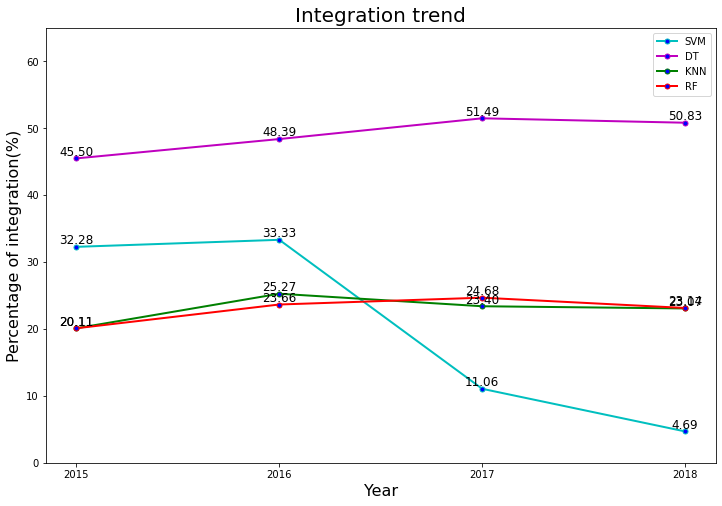

In [41]:
# Create a figure to show the predicted integration trend
plt.figure(figsize=(12,8))
plt.plot(year_list,SVM_pct,label='SVM',linewidth=2,color='c',marker='o',markerfacecolor='blue',markersize=5)
plt.plot(year_list,DT_pct,label='DT',linewidth=2,color='m',marker='o',markerfacecolor='blue',markersize=5)
plt.plot(year_list,KNN_pct,label='KNN',linewidth=2,color='g',marker='o',markerfacecolor='blue',markersize=5)
plt.plot(year_list,RF_pct,label='RF',linewidth=2,color='r',marker='o',markerfacecolor='blue',markersize=5)
add_label(year_list,SVM_pct)
add_label(year_list,DT_pct)
add_label(year_list,KNN_pct)
add_label(year_list,RF_pct)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Percentage of integration(%)', fontsize=16)
plt.ylim([0, 65])
plt.title('Integration trend', fontsize=20)
plt.legend()
plt.show()

In [42]:
print('Compute coincidence rate for KNN and RF: ')

accuracy_score(y_knn_2015, y_rf_2015), accuracy_score(y_knn_2016, y_rf_2016), accuracy_score(y_knn_2017, y_rf_2017), accuracy_score(y_knn_2018, y_rf_2018)

Compute coincidence rate for KNN and RF


(0.8412698412698413, 0.8548387096774194, 0.8595744680851064, 0.882480173035328)